# Medical cost prediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle


import warnings
warnings.filterwarnings("ignore")


sns.set_style("whitegrid")

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
print('Shape of the data', df.shape)



print("_________________________________________________")
print(df.info())


print("____________________________________________________________")
print(df.describe())

Shape of the data (1338, 7)
_________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
____________________________________________________________
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.00000

### Checking Missing Values

In [4]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## EDA

## Correlation of the variables

In [5]:
df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


charges and age have the highest correlation

## Age

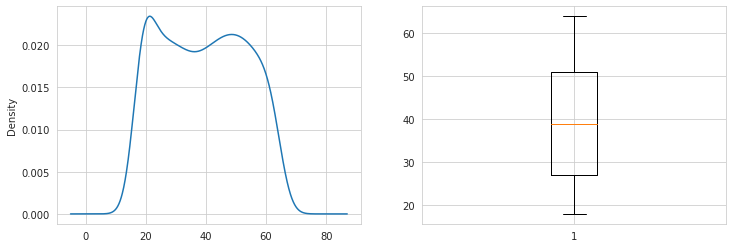

In [6]:
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
df['age'].plot(kind='kde')
f.add_subplot(1,2,2)
plt.boxplot(df['age'])
plt.show()

## BMI

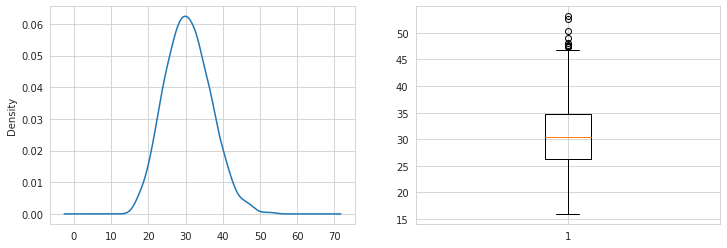

In [7]:
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
df['bmi'].plot(kind='kde')
f.add_subplot(1,2,2)
plt.boxplot(df['bmi'])
plt.show()

### Remove outliers using Z score

we using Zscore because bmi variable follow the normal distribution and Zscore can quantify the unusualness of an observation in our data.

In [8]:
#find Zscore
df['zscore'] = (df.bmi - df.bmi.mean()) / df.bmi.std()
df.head()

,age,sex,bmi,children,smoker,region,charges,zscore
0,19,female,27.900,0,yes,southwest,16884.92400,-0.453151
1,18,male,33.770,1,no,southeast,1725.55230,0.509431
2,28,male,33.000,3,no,southeast,4449.46200,0.383164
3,33,male,22.705,0,no,northwest,21984.47061,-1.305043
4,32,male,28.880,0,no,northwest,3866.85520,-0.292447


so here is 4 outliers from df['bmi']

In [9]:
#find the outliers
df[(df.zscore<-3) | (df.zscore>3)]

,age,sex,bmi,children,smoker,region,charges,zscore
116,58,male,49.06,0,no,southeast,11381.3254,3.016733
847,23,male,50.38,1,no,southeast,2438.0552,3.233191
1047,22,male,52.58,1,yes,southeast,44501.3982,3.593954
1317,18,male,53.13,0,no,southeast,1163.4627,3.684145


In [10]:
#removing outliers
df = df[(df.zscore>-3) & (df.zscore<3)]
df.shape

(1334, 8)

### Classifying BMI to Categories

In [11]:
conditions = [
    (df['bmi'] <= 18.5),
    (df['bmi'] >= 18.5) & (df['bmi'] <= 24.986),
    (df['bmi'] >= 25) & (df['bmi'] <= 29.926),
    (df['bmi'] >= 30)
    ]

values = ['underweight', 'normal', 'overweight', 'obese']

df['bmi_categories'] = np.select(conditions, values)
df.head()

,age,sex,bmi,children,smoker,region,charges,zscore,bmi_categories
0,19,female,27.900,0,yes,southwest,16884.92400,-0.453151,overweight
1,18,male,33.770,1,no,southeast,1725.55230,0.509431,obese
2,28,male,33.000,3,no,southeast,4449.46200,0.383164,obese
3,33,male,22.705,0,no,northwest,21984.47061,-1.305043,normal
4,32,male,28.880,0,no,northwest,3866.85520,-0.292447,overweight


In [12]:
# Count the numbers of each values in bmi_categories
print('underweight BMI : ', df[df['bmi_categories'] == 'underweight']['bmi_categories'].count())
print('normal BMI : ', df[df['bmi_categories'] == 'normal']['bmi_categories'].count())
print('overweight BMI : ', df[df['bmi_categories'] == 'overweight']['bmi_categories'].count())
print('obese BMI : ', df[df['bmi_categories'] == 'obese']['bmi_categories'].count())

underweight BMI :  21
normal BMI :  224
overweight BMI :  386
obese BMI :  703


Text(0.5, 1.0, 'Counts of BMI categories')

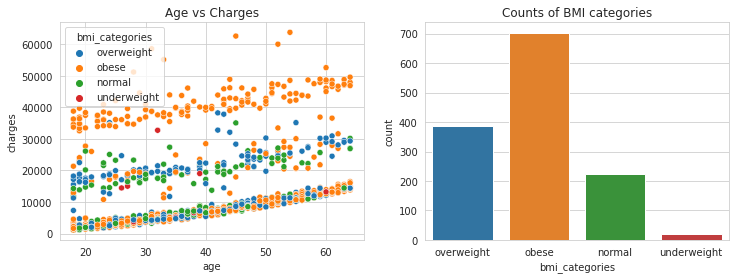

In [13]:
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
ax = sns.scatterplot(x='age', y='charges', hue = 'bmi_categories', data=df)
plt.title('Age vs Charges')
ax.plot()
f.add_subplot(1,2,2)
sns.countplot(x = df['bmi_categories'], data=df)
plt.title('Counts of BMI categories')

most people in our data is obese and they tend to pay more for the medical cost

## Smoker

Text(0.5, 1.0, 'smoker vs non-smoker')

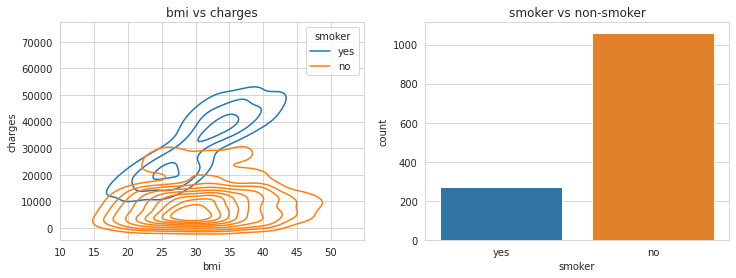

In [14]:
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
ax = sns.kdeplot(x='bmi', y='charges', hue = 'smoker', data=df)
plt.title('bmi vs charges')
ax.plot()
f.add_subplot(1,2,2)
sns.countplot(x = df['smoker'], data=df)
plt.title('smoker vs non-smoker')


* most of people in data are non-smoker
* the smoker people tend to pay more medical cost

## Sex

Text(0.5, 1.0, 'total amount of female & male')

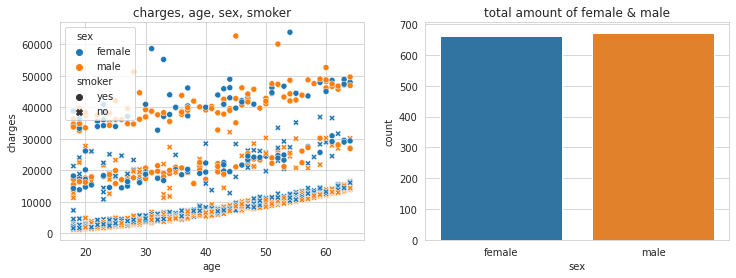

In [15]:
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
ax = sns.scatterplot(x='age', y='charges', hue = 'sex', style = 'smoker', data=df)
ax.plot()
plt.title('charges, age, sex, smoker')


f.add_subplot(1,2,2)
sns.countplot(x = df['sex'], data=df)
plt.title('total amount of female & male')

Male or female smokers have higher medical cost than non-smokers

In [16]:
print('Female : ', df[df['sex']=='female']['smoker'].count())
print('Male : ', df[df['sex']=='male']['sex'].count())

Female :  662
Male :  672


[]

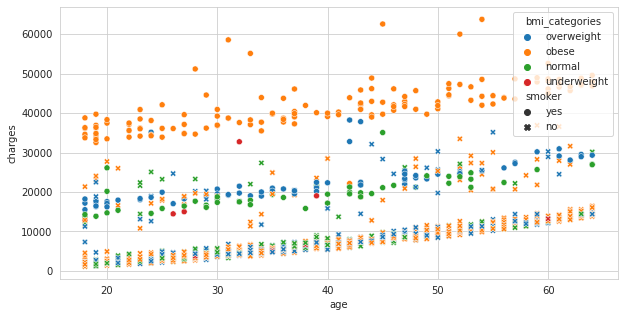

In [17]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x="age", y="charges", hue = "bmi_categories", style = 'smoker', data=df)
ax.plot()

In [18]:
df.groupby(['sex', 'smoker', 'bmi_categories'] )['bmi_categories'].count()

sex     smoker  bmi_categories
female  no      normal             88
                obese             282
                overweight        168
                underweight         9
        yes     normal             28
                obese              52
                overweight         31
                underweight         4
male    no      normal             86
                obese             277
                overweight        144
                underweight         7
        yes     normal             22
                obese              92
                overweight         43
                underweight         1
Name: bmi_categories, dtype: int64

* smokers are mostly men and obese
* non-smoker women are mostly obese and overweight

## Children

<AxesSubplot:xlabel='children', ylabel='count'>

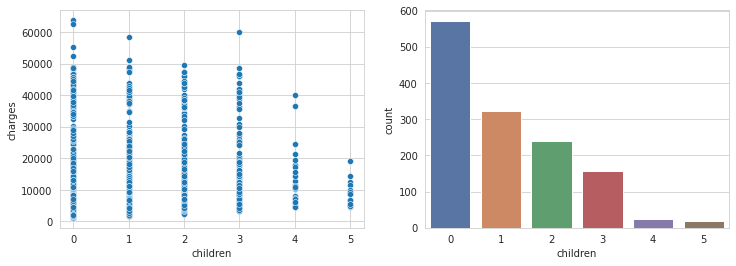

In [19]:
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
sns.scatterplot(x = 'children', y = 'charges', data = df,  palette = 'deep')
f.add_subplot(1,2,2)
sns.countplot(x = df['children'], data=df,  palette = 'deep')


most of data is people without child and they have higher mediacal costs than people with > 3 children

## Region

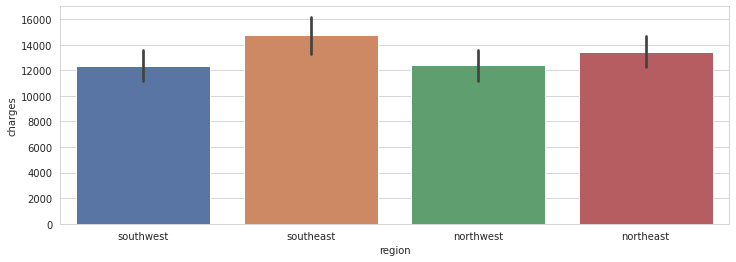

In [20]:
f = plt.figure(figsize=(12,4))
sns.barplot(x = 'region', y = 'charges', data = df,  palette = 'deep')
plt.show()

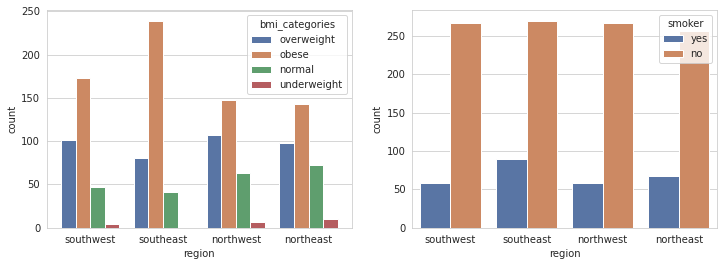

In [21]:
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
ax = sns.countplot(x='region', hue='bmi_categories', data=df, palette = 'deep')
ax.plot()
f.add_subplot(1,2,2)
ax = sns.countplot(x='region', hue='smoker', data=df, palette = 'deep')


* people in southeast have higher medical cost
* southeast has the highest number of obese people
* in each region there are more non-smokers and obese people

## Charges

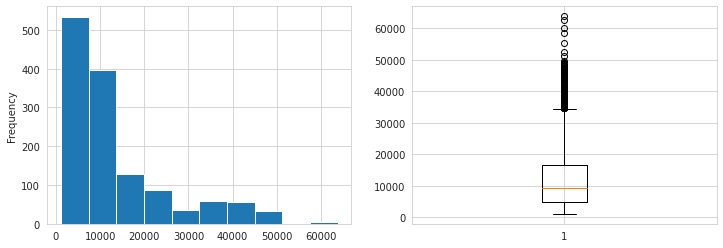

In [22]:
f = plt.figure(figsize=(12,4))
f.add_subplot(1,2,1)
df['charges'].plot(kind='hist')
f.add_subplot(1,2,2)
plt.boxplot(df['charges'])
plt.show()


Because charges variable have a right distribution and a lot of the outliers can't   be filtered out so we use log transformation
for helps reducing skewness.


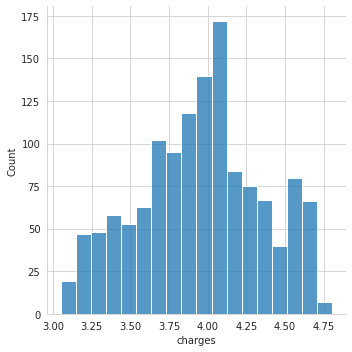

In [23]:
df['charges'] = np.log10(df['charges'])
sns.displot(df['charges'])

In [24]:
df.drop(['zscore'], axis = 1, inplace = True)

## Data Preprocessing

* Label encoding : ['sex', 'smoker', 'region', 'bmi_categories']
* standard scaling 

In [25]:
le = LabelEncoder()

df['sex'] = le.fit_transform(df['sex'])
# df['sex'].unique()

df['smoker'] = le.fit_transform(df['smoker'])
# df['sex'].unique()

df['region'] = le.fit_transform(df['region'])
# df['region'].unique()

df['bmi_categories'] = le.fit_transform(df['bmi_categories'])
# df['bmi_categories'].unique()

df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_categories
0,19,0,27.900,0,1,3,4.227499,2
1,18,1,33.770,1,0,2,3.236928,1
2,28,1,33.000,3,0,2,3.648308,1
3,33,1,22.705,0,0,1,4.342116,0
4,32,1,28.880,0,0,1,3.587358,2


In [26]:
y= df['charges']
X = df.drop(['charges'], axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state = 42)
X_train.shape, X_test.shape

((1067, 7), (267, 7))

### Modeling

#### Linear regression

In [27]:
steps = [('scaler', StandardScaler()), 
         ('linreg', LinearRegression())]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

score = pipe.score(X_test, y_test)
linreg_score = round(score, 4)
mse_linreg = mean_squared_error(y_test, y_pred)
rmse_linreg = np.sqrt(mean_squared_error(y_test,y_pred))

#### Polynomial regression

In [28]:
steps = [('scaler', StandardScaler()), 
         ('kmethdonn', PolynomialFeatures(degree=4)),
         ('model',LinearRegression())]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

score = pipe.score(X_test, y_test)
poly_score = round(score, 4)
mse_poly = mean_squared_error(y_test, y_pred)
rmse_poly = np.sqrt(mean_squared_error(y_test,y_pred))

#### KNN regression
find the best K value

<AxesSubplot:>

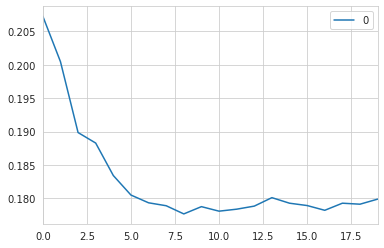

In [29]:
from sklearn import neighbors

rmse_val = [] 
for K in range(20):
    K = K+1
    steps = [('scaler', StandardScaler()), 
         ('knn', KNeighborsRegressor(n_neighbors = K))]
    model = Pipeline(steps)

    model.fit(X_train, y_train) 
    pred=model.predict(X_test) 
    error = sqrt(mean_squared_error(y_test,pred)) 
    rmse_val.append(error) 
#     print('RMSE value for k= ' , K , 'is:', error)

curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [30]:
index = rmse_val.index(min(rmse_val))
print('Optimal K : ', index)

Optimal K :  8


In [31]:
steps = [('scaler', StandardScaler()), 
         ('knn', KNeighborsRegressor(n_neighbors = 8))]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

score = pipe.score(X_test, y_test)
knn_score = round(score, 4)
mse_knn = mean_squared_error(y_test, y_pred)
rmse_knn = np.sqrt(mean_squared_error(y_test,y_pred))

#### DecisionTree regression

In [32]:
steps = [('scaler', StandardScaler()), 
         ('dt', DecisionTreeRegressor(max_depth = 3))]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

score = pipe.score(X_test, y_test)
dt_score = round(score, 4)
mse_dt = mean_squared_error(y_test, y_pred)
rmse_dt = np.sqrt(mean_squared_error(y_test,y_pred))

#### Comparing the model 

                     model   score       MSE      RMSE
0        Linear Regression  0.7721  0.037439  0.193491
1     Polynomia Regression  0.7552  0.040222  0.200554
2           KNN Regression  0.8052  0.031998  0.178879
3  DecisionTree Regression  0.8105  0.031124  0.176421 



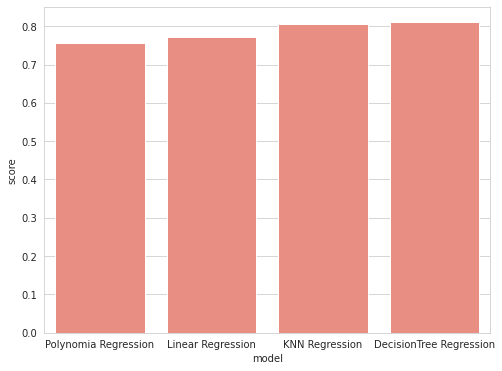

In [33]:
score = [['Linear Regression', linreg_score, mse_linreg, rmse_linreg],
         ['Polynomia Regression', poly_score, mse_poly, rmse_poly],
         ['KNN Regression', knn_score, mse_knn, rmse_knn],
         ['DecisionTree Regression', dt_score, mse_dt, rmse_dt]]
         
models = pd.DataFrame(score)
models.columns = ['model', 'score', 'MSE', 'RMSE']
print (models,'\n')

plt.figure(figsize=(8,6))
sns.barplot(x = 'model', 
            y = 'score', 
            data = models, 
            color = 'salmon',
            order=models.sort_values('score').model)
plt.show()

So we'll take decisiontree for our model

### Cross Validation

In [34]:
# Hyper parameters range intialization for tuning 

parameters={'dt__criterion':['squared_error', 'absolute_error', 'friedman_mse'],
            'dt__splitter':['best', 'random'],
            'dt__max_depth' : [2,3,4,5,6,7,9,12],
           'dt__min_samples_leaf':[2,3,4,5,6,7,8],
            'dt__min_weight_fraction_leaf':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           'dt__max_features':['auto', 'log2', 'sqrt',None]}

tuning = GridSearchCV(pipe, param_grid=parameters,scoring='neg_mean_squared_error',cv=5)
tuning.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dt',
                                        DecisionTreeRegressor(max_depth=3))]),
             param_grid={'dt__criterion': ['squared_error', 'absolute_error',
                                           'friedman_mse'],
                         'dt__max_depth': [2, 3, 4, 5, 6, 7, 9, 12],
                         'dt__max_features': ['auto', 'log2', 'sqrt', None],
                         'dt__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8],
                         'dt__min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9],
                         'dt__splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [35]:
print('best parameter :', tuning.best_params_)
print('best score :', tuning.best_score_)

best parameter : {'dt__criterion': 'friedman_mse', 'dt__max_depth': 4, 'dt__max_features': 'auto', 'dt__min_samples_leaf': 3, 'dt__min_weight_fraction_leaf': 0.1, 'dt__splitter': 'best'}
best score : -0.035918758718837075


### Training Decision Tree With Best Hyperparameters

In [36]:
steps = [('scaler', StandardScaler()), 
         ('dt', DecisionTreeRegressor(criterion = 'friedman_mse', 
                                      max_depth =  4,
                                      max_features = None,
                                      min_samples_leaf =  4,
                                      min_weight_fraction_leaf =  0.1,
                                      splitter =  'best'))]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

score = pipe.score(X_test, y_test)
print('score : ', round(score, 4)*100)
print('MSE :', mean_squared_error(y_test, y_pred))
print('RMSE :', np.sqrt(mean_squared_error(y_test,y_pred)))

score :  80.4
MSE : 0.03220440783374481
RMSE : 0.17945586597752888


notice that MSE and RMSE score has decreased

In [37]:
#final model
tuning.best_estimator_.fit(X_train,y_train)
filename = 'insurance.pkl'
pickle.dump(tuning.best_estimator_,open(filename,'wb'))

In [39]:
print(tuning.predict([[19, 0, 22.705, 0, 0, 2, 0]]))

[3.37706258]
